In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Dropout, Lambda,Conv2D, Conv2DTranspose,MaxPooling2D,concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [3]:
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

In [4]:
seed=40
random.seed = seed
np.random.seed = seed

In [5]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [6]:
print("Number of training images:")
print(len(train_ids))

Number of training images:
670


In [7]:
print("Number of testing images:")
print(len(test_ids))

Number of testing images:
65


In [8]:
from tqdm.notebook import tqdm

In [9]:
#input training images and masks:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
sys.stdout.flush()
tr_ids=enumerate(train_ids)
for n, id_ in tqdm(tr_ids):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

In [10]:
from PIL import Image
from IPython.display import display

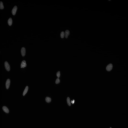

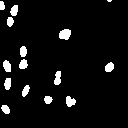

In [11]:
#example train image and mask
ix = random.randint(0, len(train_ids))
display(Image.fromarray(X_train[ix]))
display(Image.fromarray(np.squeeze(Y_train[ix])))


In [12]:
#input testing images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img


In [13]:
print(np.shape(X_test))

(65, 128, 128, 3)


In [14]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)


c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2),strides=2) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2),strides=2) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (p2)
c3 = Dropout(0.1) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2),strides=2) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
c4 = Dropout(0.1) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2),strides=2) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
c5 = Dropout(0.1) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (u6)
c6 = Dropout(0.1) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (u7)
c7 = Dropout(0.1) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (

In [ ]:
#fitting the model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('u-net-segmentation.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
592/603 [============================>.] - ETA: 1s - loss: 9.2144 - acc: 0.8001
Epoch 00001: val_loss improved from inf to 6.81255, saving model to u-net-segmentation.h5
603/603 [==============================] - 86s 143ms/step - loss: 9.1351 - acc: 0.7998 - val_loss: 6.8125 - val_acc: 0.7835
Epoch 2/50
592/603 [============================>.] - ETA: 1s - loss: 5.5888 - acc: 0.8279
Epoch 00002: val_loss improved from 6.81255 to 4.58314, saving model to u-net-segmentation.h5
603/603 [==============================] - 88s 146ms/step - loss: 5.5368 - acc: 0.8295 - val_loss: 4.5831 - val_acc: 0.8833
Epoch 3/50
592/603 [============================>.] - ETA: 1s - loss: 3.5315 - acc: 0.9132
Epoch 00003: val_loss improved from 4.58314 to 3.27193, saving model to u-net-segmentation.h5
603/603 [==============================] - 87s 145ms/step - loss: 3.4954 - acc: 0.9138 - val_loss: 3.2719 - val_acc: 0.9139
Epoch 4/50
592/603 [============

Epoch 29/50
592/603 [============================>.] - ETA: 1s - loss: 1.2476 - acc: 0.9693
Epoch 00029: val_loss improved from 1.28507 to 1.23415, saving model to u-net-segmentation.h5
603/603 [==============================] - 86s 143ms/step - loss: 1.2500 - acc: 0.9689 - val_loss: 1.2342 - val_acc: 0.9686
Epoch 30/50
592/603 [============================>.] - ETA: 1s - loss: 1.2601 - acc: 0.9690
Epoch 00030: val_loss did not improve from 1.23415
603/603 [==============================] - 87s 144ms/step - loss: 1.2479 - acc: 0.9691 - val_loss: 1.2591 - val_acc: 0.9673
Epoch 31/50
592/603 [============================>.] - ETA: 1s - loss: 1.2698 - acc: 0.9687
Epoch 00031: val_loss did not improve from 1.23415
603/603 [==============================] - 86s 143ms/step - loss: 1.2587 - acc: 0.9689 - val_loss: 1.2815 - val_acc: 0.9677
Epoch 32/50
144/603 [======>.......................] - ETA: 1:28:58 - loss: 1.4271 - acc: 0.9659

1/1 [==============================] - 0s 211ms/step
sample training image


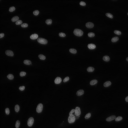

prediction mask for the training image:


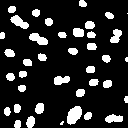

acutal mask for the training image:


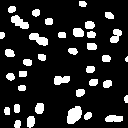

In [15]:
import cv2
#testing on the training sample
ix = random.randint(0, len(train_ids))
model = load_model('u-net-segmentation.h5')
img_pred = np.expand_dims(X_train[ix], axis=0)
pred=model.predict(img_pred, verbose=1)
img=(cv2.cvtColor(np.squeeze((np.round(pred))*255), cv2.COLOR_GRAY2BGR)).astype(np.uint8)
print("sample training image")
display(Image.fromarray(X_train[ix]))
print("prediction mask for the training image:")
display(Image.fromarray(img))
print("acutal mask for the training image:")
display(Image.fromarray(np.squeeze(Y_train[ix])))


1/1 [==============================] - 3s 3s/step
sample test image


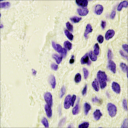

prediction mask for the test image:


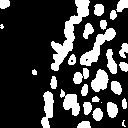

In [26]:
import cv2
from tensorflow.keras.models import Model, load_model
#testing on the testing sample
ix = random.randint(0, len(test_ids))
model = load_model('u-net-segmentation.h5')
img_pred = np.expand_dims(X_test[ix], axis=0)
pred=model.predict(img_pred, verbose=1)
img=(cv2.cvtColor(np.squeeze((np.round(pred))*255), cv2.COLOR_GRAY2BGR)).astype(np.uint8)
print("sample test image")
display(Image.fromarray(X_test[ix]))
print("prediction mask for the test image:")
display(Image.fromarray(img))
